In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:

# Normalization constants for CIFAR-10 (per RGB channel)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

In [4]:
# Download CIFAR-10 dataset and store them in ./data directory

data_root = "../data"

train_full = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)

test_ds = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform,
)

In [5]:
print("train:", len(train_full))
print("test:", len(test_ds))
print("classes:", train_full.classes)

train: 50000
test: 10000
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
# Split training dataset into train and validation sets

val_size = 5000
train_size = len(train_full) - val_size

train_ds, val_ds = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

len(train_ds), len(val_ds)

(45000, 5000)

In [7]:
# Create the data loaders
batch_size = 128
num_workers = 0 

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [8]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [9]:
class MLPBaseline(nn.Module):
    def __init__(self, hidden_dim=512, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.flatten(x)          # (B, 3, 32, 32) -> (B, 3072)
        x = F.relu(self.fc1(x))      # (B, hidden_dim)
        x = self.fc2(x)              # (B, num_classes) logits
        return x

mlp = MLPBaseline(hidden_dim=512, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)


In [10]:
# 0) limpiar gradientes al inicio del step (evita acumulación accidental)
optimizer.zero_grad()

# 1) forward
logits = mlp(xb)

# 2) loss
loss = criterion(logits, yb)

# 3) backward (crea gradientes)
loss.backward()

# 4) inspección (aquí SI existen los gradientes)
print("fc1.weight.grad is None?", mlp.fc1.weight.grad is None)
print("fc1.weight.grad shape:", mlp.fc1.weight.grad.shape)
print("mean |grad|:", mlp.fc1.weight.grad.abs().mean().item())

# 5) update pesos
optimizer.step()

loss.item()

fc1.weight.grad is None? False
fc1.weight.grad shape: torch.Size([512, 3072])
mean |grad|: 0.001450972631573677


2.3331780433654785

In [11]:
#Now let's define the training step function for all batchs 
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # training step
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        # bookkeeping
        total_loss += loss.item() * xb.size(0)

        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_samples += xb.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


In [12]:
train_loss, train_acc = train_one_epoch(
    mlp, train_loader, criterion, optimizer, device
)

train_loss, train_acc

(1.7046472429275512, 0.416)

In [13]:
def evaluate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * xb.size(0)

            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += xb.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

In [14]:
val_loss, val_acc = evaluate(
    mlp, val_loader, criterion, device
)

val_loss, val_acc

(1.538858579826355, 0.4654)

### CNN

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32x32 -> 16x16

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 16x16 -> 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [16]:
cnn = SimpleCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

cnn


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [17]:
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device)

logits = cnn(xb)
logits.shape

torch.Size([128, 10])

In [18]:
train_loss_cnn, train_acc_cnn = train_one_epoch(
    cnn, train_loader, criterion, optimizer, device
)

train_loss_cnn, train_acc_cnn

(1.4002999457465277, 0.5075333333333333)

In [19]:
val_loss_cnn, val_acc_cnn = evaluate(
    cnn, val_loader, criterion, device
)

val_loss_cnn, val_acc_cnn

(1.1561440475463867, 0.5928)

In [20]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(
            f"Epoch {epoch:02d} | "
            f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
            f"val loss {va_loss:.4f} acc {va_acc:.4f}"
        )

    return history

# (re)initialize model to make the experiment clean
cnn = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

history_cnn = fit(cnn, train_loader, val_loader, criterion, optimizer, device, epochs=5)

Epoch 01 | train loss 1.3953 acc 0.5055 | val loss 1.1282 acc 0.6102
Epoch 02 | train loss 1.0335 acc 0.6406 | val loss 0.9874 acc 0.6622
Epoch 03 | train loss 0.9037 acc 0.6894 | val loss 0.9487 acc 0.6714
Epoch 04 | train loss 0.8230 acc 0.7202 | val loss 0.8954 acc 0.6880
Epoch 05 | train loss 0.7556 acc 0.7413 | val loss 0.8620 acc 0.6998


In [21]:
mlp = MLPBaseline(hidden_dim=512, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

history_mlp = fit(
    mlp,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=5
)


Epoch 01 | train loss 1.7118 acc 0.4105 | val loss 1.5783 acc 0.4506
Epoch 02 | train loss 1.4697 acc 0.4883 | val loss 1.5082 acc 0.4808
Epoch 03 | train loss 1.3925 acc 0.5187 | val loss 1.4847 acc 0.4968
Epoch 04 | train loss 1.3274 acc 0.5430 | val loss 1.4788 acc 0.4992
Epoch 05 | train loss 1.2640 acc 0.5659 | val loss 1.5314 acc 0.4918


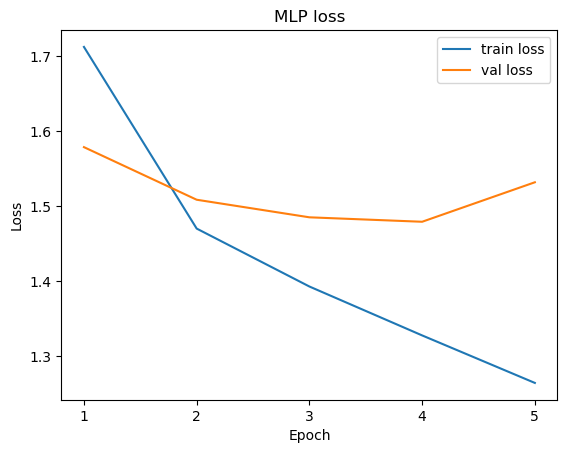

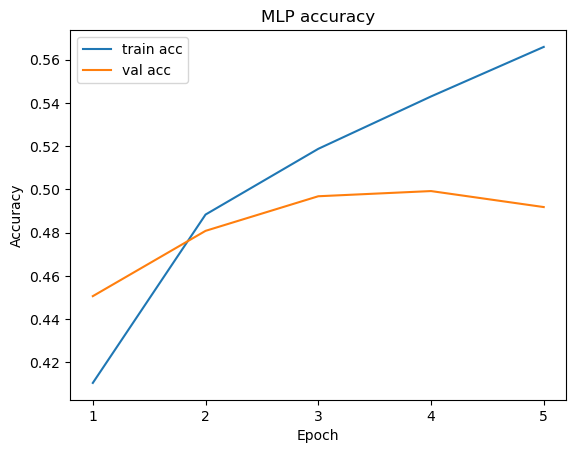

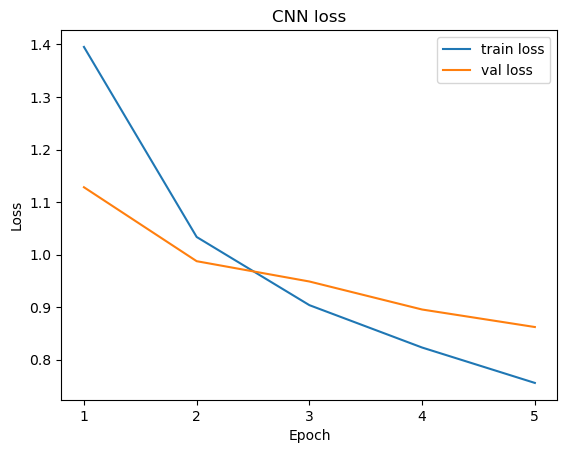

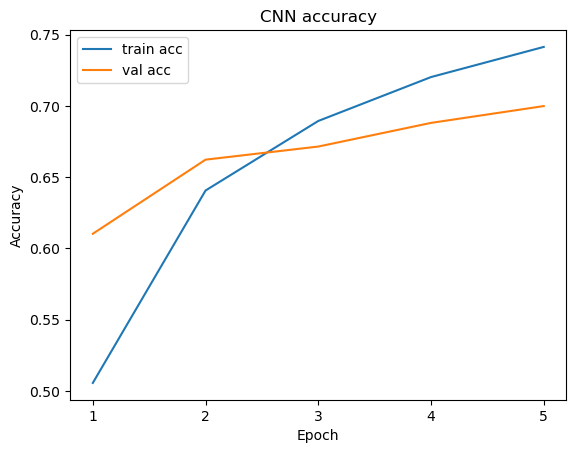

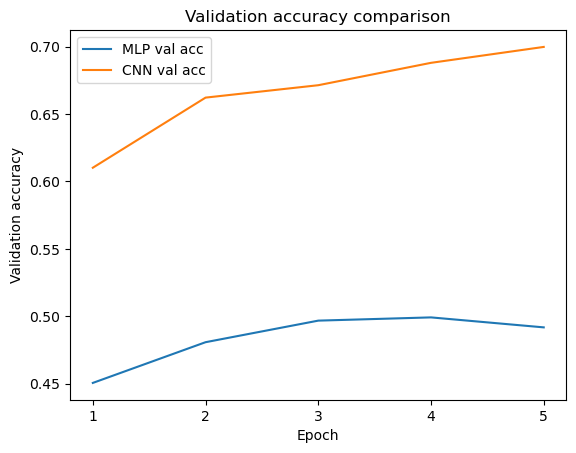

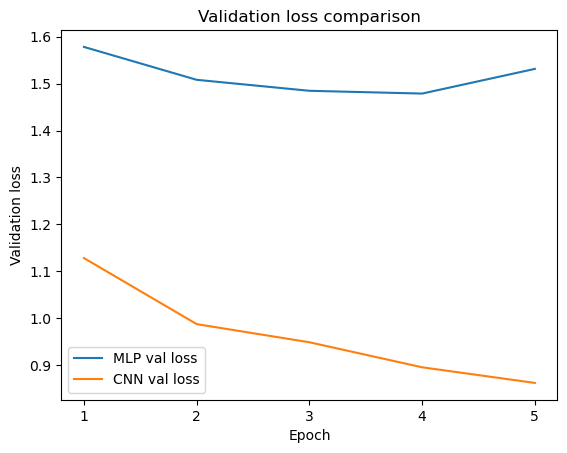

In [22]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix=""):
    epochs = list(range(1, len(history["train_loss"]) + 1))

    # Loss
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} loss".strip())
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} accuracy".strip())
    plt.xticks(epochs)
    plt.legend()
    plt.show()


# 1) Curvas por modelo
plot_history(history_mlp, "MLP")
plot_history(history_cnn, "CNN")


# 2) Comparación directa (val)
epochs = list(range(1, len(history_cnn["val_acc"]) + 1))

plt.figure()
plt.plot(epochs, history_mlp["val_acc"], label="MLP val acc")
plt.plot(epochs, history_cnn["val_acc"], label="CNN val acc")
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy comparison")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history_mlp["val_loss"], label="MLP val loss")
plt.plot(epochs, history_cnn["val_loss"], label="CNN val loss")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("Validation loss comparison")
plt.xticks(epochs)
plt.legend()
plt.show()